In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators= 100, random_state= 10)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    lr = LinearRegression()
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.01)
    gpr1 = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(),random_state=0)
    gpr2 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3))+ 
                                WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)),alpha=0.0)
    gpr3 = GaussianProcessRegressor(kernel=ConstantKernel(1.0, (1e-2, 1e3)) * RBF(10, (1e-3, 1e4)),
                                n_restarts_optimizer=9)
    gpr4 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)))
    gpr5 = GaussianProcessRegressor(kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.01))
    gpr6 = GaussianProcessRegressor(kernel=1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 10.0),nu=0.35))
    models = [rf,gb,lr,rr,lasso,gpr1,gpr2,gpr3,gpr4,gpr5,gpr6]
    models_names = ["RF","GB","LR","RR","LASSO","gpr1","gpr2","gpr3","gpr4","gpr5","gpr6"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        predicted_y = []
        expected_y = []
        kf = KFold(n_splits= 10) 
        # partition data
        for train_index, test_index in kf.split(X, Y):
            # specific ".loc" syntax for working with dataframes
            x_train, x_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            # create and fit classifier
            model.fit(x_train, y_train)

            # store result from classification
            predicted_y.extend(model.predict(x_test))

            # store expected result for this specific fold
            expected_y.extend(y_test)
        
        r2 = metrics.r2_score(expected_y, predicted_y)
        r2scores.append(r2)
        
        err=np.sqrt(metrics.mean_squared_error(expected_y, predicted_y))
        rmse.append(err)
        
        print(models_names[count])
        print("R2: ",r2.__str__())
        print("RMSE: ",err)
        print("---------------------------------------")
        count+=1
    
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    #plt.show()
    print(r2scores)

# Standard Scaling

In [4]:
data_std = pd.read_csv('scaled_standard_Coeff_D.csv', encoding='cp1252')   

In [5]:
data_std.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_D'], dtype=object)

In [6]:
data_std.drop(['density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
           'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF'
          ], axis=1, inplace = True)

In [7]:
data_std.fillna(0, inplace= True)

In [8]:
Y = data_std['Coeff_D'] 
X = data_std.drop(['Coeff_D','Name'], axis=1)

### Using CV technique

RF
R2:  0.9100458667887377
RMSE:  0.29992354560998097
---------------------------------------
GB
R2:  0.8634502397493096
RMSE:  0.3695263999373934
---------------------------------------
LR
R2:  -2.4630901415524535e+23
RMSE:  496295289273.6796
---------------------------------------
RR
R2:  0.6166937703685604
RMSE:  0.6191172987661059
---------------------------------------
LASSO
R2:  0.9236649903965249
RMSE:  0.27628791070815073
---------------------------------------
gpr1
R2:  0.8694797485715102
RMSE:  0.3612758661030236
---------------------------------------
gpr2
R2:  0.9390292011111486
RMSE:  0.2469226577065202
---------------------------------------
gpr3
R2:  0.8982908535586606
RMSE:  0.31891871447335823
---------------------------------------
gpr4
R2:  0.8982908652549789
RMSE:  0.3189186961358977
---------------------------------------
gpr5
R2:  0.9324642419720284
RMSE:  0.25987642838082026
---------------------------------------
gpr6
R2:  0.8582748182959409
RMSE:  0.37646405101

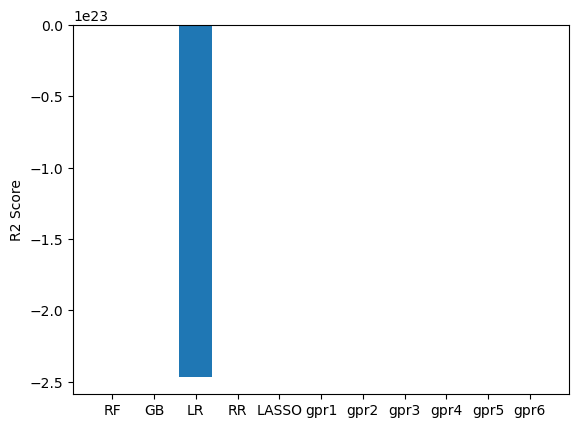

In [9]:
run_models()

## Feature selection


In [10]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

    Feature      Score
14     X_EA  95.321460
22   X_Rvdw  86.377832
2       X_Z  57.377112
5       X_G  42.601054
11   X_IEII  29.416755
20   A_Rvdw  27.279924
24     B_Ra  24.281635
18   A_ChiA  23.793760
6     A_IEI  23.778238
32     B_Hf  21.103010
1       B_Z  20.453363
12     A_EA  12.141141
23     B_Rc  11.926378
15   A_ChiP  11.798528
37    B_CvM  10.535518
26     B_MP  10.479821
21   B_Rvdw  10.461311
28    B_Rho   9.209004
25     A_MP   9.098591
31     X_MV   7.751609
30     B_MV   7.176187
0       A_Z   5.914470
33  A_Kappa   5.550168
17   X_ChiP   3.858279
36    A_CvM   3.560528
38      A_B   3.512358
3       A_G   3.435873
10   B_IEII   2.581042
35  X_Kappa   2.245766
39      B_B   1.987794


In [11]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'X_G', 'X_IEII', 'A_Rvdw', 'B_Ra',
       'A_ChiA', 'A_IEI', 'B_Hf', 'B_Z', 'A_EA', 'B_Rc', 'A_ChiP',
       'B_CvM', 'B_MP', 'B_Rvdw', 'B_Rho', 'A_MP', 'X_MV', 'B_MV', 'A_Z',
       'A_Kappa', 'X_ChiP', 'A_CvM', 'A_B', 'A_G', 'B_IEII', 'X_Kappa',
       'B_B', 'B_Kappa', 'B_EA', 'B_G', 'A_Rho', 'X_IEI', 'B_ChiP',
       'B_ChiA', 'A_IEII', 'X_Rho', 'B_IEI'], dtype=object)

In [12]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.9087798449488369
RMSE:  0.30202674558913334
---------------------------------------
GB
R2:  0.8574282736902461
RMSE:  0.3775867136298017
---------------------------------------
LR
R2:  -4.9039761875639604e+22
RMSE:  221449230921.3098
---------------------------------------
RR
R2:  0.5487428999547534
RMSE:  0.6717567268328963
---------------------------------------
LASSO
R2:  0.923868021859718
RMSE:  0.27592023872902477
---------------------------------------
gpr1
R2:  0.8634951956022149
RMSE:  0.3694655659162097
---------------------------------------
gpr2
R2:  0.9393531219934214
RMSE:  0.24626586853760035
---------------------------------------
gpr3
R2:  0.9013844946909495
RMSE:  0.3140310578733424
---------------------------------------
gpr4
R2:  0.9013844903174941
RMSE:  0.31403106483675447
---------------------------------------
gpr5
R2:  0.9332970699344297
RMSE:  0.2582691039702006
---------------------------------------
gpr6
R2:  0.8617921916804079
RMSE:  0.371763107797

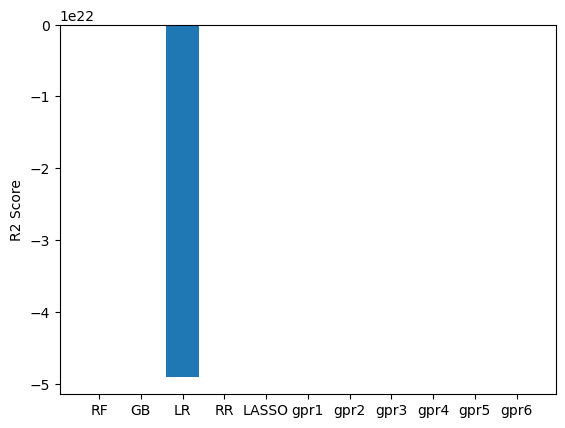

In [13]:
run_models()

In [14]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'X_G', 'X_IEII', 'A_Rvdw', 'B_Ra',
       'A_ChiA', 'A_IEI', 'B_Hf', 'B_Z', 'A_EA', 'B_Rc', 'A_ChiP',
       'B_CvM', 'B_MP', 'B_Rvdw', 'B_Rho', 'A_MP', 'X_MV', 'B_MV', 'A_Z',
       'A_Kappa', 'X_ChiP', 'A_CvM', 'A_B', 'A_G', 'B_IEII', 'X_Kappa',
       'B_B'], dtype=object)

In [15]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.9137664011135802
RMSE:  0.2936555786740987
---------------------------------------
GB
R2:  0.8658542982029185
RMSE:  0.36625906377464773
---------------------------------------
LR
R2:  -3.754897581027469e+21
RMSE:  61277219103.248055
---------------------------------------
RR
R2:  0.8180252969545149
RMSE:  0.42658493063572367
---------------------------------------
LASSO
R2:  0.9248629182237883
RMSE:  0.27411144043292274
---------------------------------------
gpr1
R2:  0.9296534152065314
RMSE:  0.2652293060607529
---------------------------------------
gpr2
R2:  0.9387225124870606
RMSE:  0.2475429003484837
---------------------------------------
gpr3
R2:  0.7524878247131404
RMSE:  0.4975059550265299
---------------------------------------
gpr4
R2:  0.8376853548155903
RMSE:  0.40288291746413085
---------------------------------------
gpr5
R2:  0.9266153813032143
RMSE:  0.2708959554825168
---------------------------------------
gpr6
R2:  0.8793581766855406
RMSE:  0.34733531826

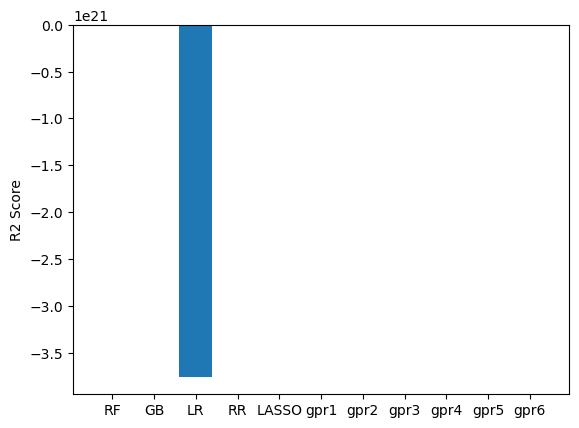

In [16]:
run_models()

In [17]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'X_G', 'X_IEII', 'A_Rvdw', 'B_Ra',
       'A_ChiA', 'A_IEI', 'B_Hf', 'B_Z', 'A_EA', 'B_Rc', 'A_ChiP',
       'B_CvM', 'B_MP', 'B_Rvdw', 'B_Rho', 'A_MP', 'X_MV'], dtype=object)

In [18]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.9094638671457381
RMSE:  0.30089222797251164
---------------------------------------
GB
R2:  0.854704421153356
RMSE:  0.3811765717441774
---------------------------------------
LR
R2:  0.7815993411447805
RMSE:  0.46733356273139587
---------------------------------------
RR
R2:  0.7836660054698571
RMSE:  0.46511718365390775
---------------------------------------
LASSO
R2:  0.8796922453324653
RMSE:  0.34685408267387413
---------------------------------------
gpr1
R2:  0.8165407377482108
RMSE:  0.4283214473404165
---------------------------------------
gpr2
R2:  0.9330322693424729
RMSE:  0.2587812409304955
---------------------------------------
gpr3
R2:  0.7375289279999022
RMSE:  0.5123193066829492
---------------------------------------
gpr4
R2:  0.8273928278174592
RMSE:  0.41546019325868133
---------------------------------------
gpr5
R2:  0.9202028091149087
RMSE:  0.2824839657132619
---------------------------------------
gpr6
R2:  0.8975651540438871
RMSE:  0.320054442175253

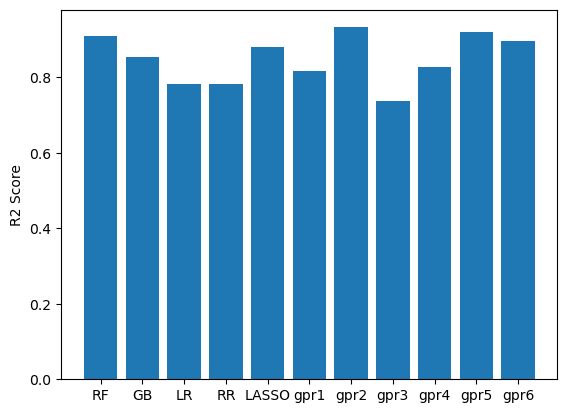

In [19]:
run_models()

In [20]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'X_G', 'X_IEII', 'A_Rvdw', 'B_Ra',
       'A_ChiA', 'A_IEI', 'B_Hf'], dtype=object)

In [21]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.908989620385948
RMSE:  0.3016792661321821
---------------------------------------
GB
R2:  0.7637980673332464
RMSE:  0.4860061035282927
---------------------------------------
LR
R2:  0.9088656566091211
RMSE:  0.3018846524599734
---------------------------------------
RR
R2:  0.9089285350973778
RMSE:  0.3017804912558501
---------------------------------------
LASSO
R2:  0.9122684846030693
RMSE:  0.296195063086694
---------------------------------------
gpr1
R2:  0.9138000118899706
RMSE:  0.293598344869363
---------------------------------------
gpr2
R2:  0.9317062383924424
RMSE:  0.2613307513622491
---------------------------------------
gpr3
R2:  0.4204499190687857
RMSE:  0.7612818669397126
---------------------------------------
gpr4
R2:  0.42044993573343203
RMSE:  0.7612818559945902
---------------------------------------
gpr5
R2:  0.8807002654873924
RMSE:  0.34539793646257877
---------------------------------------
gpr6
R2:  0.9029429988606451
RMSE:  0.3115397264224178
---

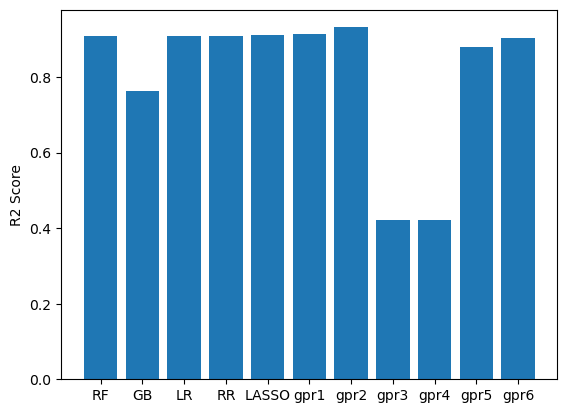

In [22]:
run_models()

# Min-Max scaling

In [23]:
data_mm = pd.read_csv('scaled_minmax_Coeff_D.csv', encoding='cp1252')

In [24]:
data_mm.drop(['density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
           'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF'
          ], axis=1, inplace = True)

In [25]:
data_mm.fillna(0, inplace= True)

In [26]:
Y = data_mm['Coeff_D'] 
X = data_mm.drop(['Coeff_D','Name'], axis=1)

### Using CV technique

RF
R2:  0.894536940844513
RMSE:  0.07466725336060477
---------------------------------------
GB
R2:  0.8849211141266472
RMSE:  0.0779969855083392
---------------------------------------
LR
R2:  -7.78035021721665e+23
RMSE:  202805424436.30466
---------------------------------------
RR
R2:  0.7861312777136417
RMSE:  0.10632946559283138
---------------------------------------
LASSO
R2:  0.7444662632681744
RMSE:  0.11622622081585257
---------------------------------------
gpr1
R2:  0.45289082688959736
RMSE:  0.1700658021820144
---------------------------------------
gpr2
R2:  0.9348304545422546
RMSE:  0.058695166601792644
---------------------------------------
gpr3
R2:  0.8665114012128233
RMSE:  0.08400440902696188
---------------------------------------
gpr4
R2:  0.8665113896885946
RMSE:  0.08400441265306183
---------------------------------------
gpr5
R2:  0.9294160391297256
RMSE:  0.061084778926167975
---------------------------------------
gpr6
R2:  0.8879702918788697
RMSE:  0.0769567

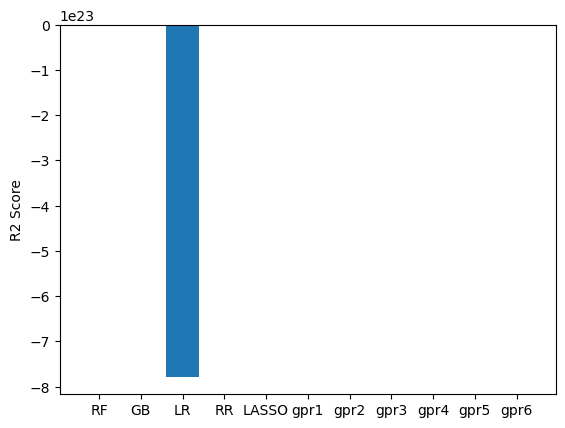

In [27]:
run_models()

## Feature selection


In [28]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

    Feature      Score
14     X_EA  95.321460
22   X_Rvdw  86.377832
2       X_Z  57.377112
5       X_G  42.601054
20   A_Rvdw  27.279924
24     B_Ra  24.281635
6     A_IEI  23.778238
18   A_ChiA  23.196933
32     B_Hf  21.103010
1       B_Z  20.453363
12     A_EA  12.141141
23     B_Rc  11.926378
15   A_ChiP  11.798528
26     B_MP  10.479821
21   B_Rvdw  10.461311
37    B_CvM  10.060408
19   B_ChiA   9.105932
25     A_MP   9.098591
28    B_Rho   8.712494
31     X_MV   7.751609
30     B_MV   7.176187
29    X_Rho   7.000829
0       A_Z   5.914470
33  A_Kappa   5.550168
17   X_ChiP   3.858279
36    A_CvM   3.560528
38      A_B   3.512358
3       A_G   3.435873
11   X_IEII   2.463861
10   B_IEII   2.462788


In [29]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'X_G', 'A_Rvdw', 'B_Ra', 'A_IEI',
       'A_ChiA', 'B_Hf', 'B_Z', 'A_EA', 'B_Rc', 'A_ChiP', 'B_MP',
       'B_Rvdw', 'B_CvM', 'B_ChiA', 'A_MP', 'B_Rho', 'X_MV', 'B_MV',
       'X_Rho', 'A_Z', 'A_Kappa', 'X_ChiP', 'A_CvM', 'A_B', 'A_G',
       'X_IEII', 'B_IEII', 'X_Kappa', 'B_B', 'B_Kappa', 'B_EA', 'B_G',
       'A_Rho', 'X_IEI', 'B_ChiP', 'A_IEII', 'B_IEI'], dtype=object)

In [30]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.8948967156703596
RMSE:  0.07453978527944917
---------------------------------------
GB
R2:  0.8663215312511401
RMSE:  0.08406413040554685
---------------------------------------
LR
R2:  -9.003360352656399e+20
RMSE:  6898939081.959181
---------------------------------------
RR
R2:  0.716561281947967
RMSE:  0.12240793774345891
---------------------------------------
LASSO
R2:  0.7444554864569173
RMSE:  0.11622867163674028
---------------------------------------
gpr1
R2:  0.09956188756605411
RMSE:  0.21817597636675837
---------------------------------------
gpr2
R2:  0.9345639714557956
RMSE:  0.05881504861169597
---------------------------------------
gpr3
R2:  0.8682158994853663
RMSE:  0.08346636535944477
---------------------------------------
gpr4
R2:  0.8682159183662799
RMSE:  0.08346635938026638
---------------------------------------
gpr5
R2:  0.9316443034263304
RMSE:  0.06011285438131577
---------------------------------------
gpr6
R2:  0.891673631039632
RMSE:  0.07567406

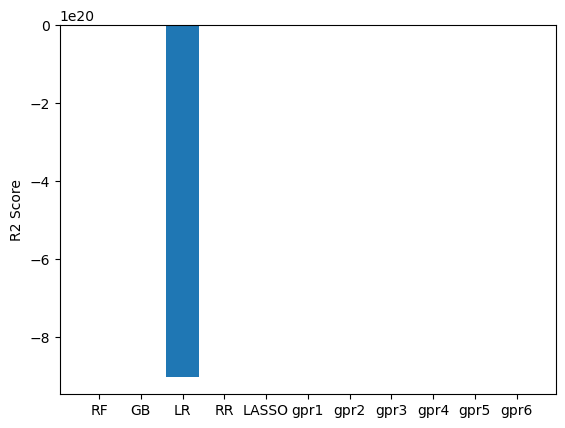

In [31]:
run_models()

In [32]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'X_G', 'A_Rvdw', 'B_Ra', 'A_IEI',
       'A_ChiA', 'B_Hf', 'B_Z', 'A_EA', 'B_Rc', 'A_ChiP', 'B_MP',
       'B_Rvdw', 'B_CvM', 'B_ChiA', 'A_MP', 'B_Rho', 'X_MV', 'B_MV',
       'X_Rho', 'A_Z', 'A_Kappa', 'X_ChiP', 'A_CvM', 'A_B', 'A_G',
       'X_IEII', 'B_IEII'], dtype=object)

In [33]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.8941375918440861
RMSE:  0.07480848821042277
---------------------------------------
GB
R2:  0.8611801121395093
RMSE:  0.0856654771746599
---------------------------------------
LR
R2:  -5.212695533410525e+20
RMSE:  5249418207.654139
---------------------------------------
RR
R2:  0.6211257965653716
RMSE:  0.14152315827606624
---------------------------------------
LASSO
R2:  0.7445940825160887
RMSE:  0.11619714871261051
---------------------------------------
gpr1
R2:  0.2733509820007579
RMSE:  0.19599380268735528
---------------------------------------
gpr2
R2:  0.9174600689449838
RMSE:  0.06605596547637217
---------------------------------------
gpr3
R2:  0.7734273554296991
RMSE:  0.10944192683109444
---------------------------------------
gpr4
R2:  0.7734273392478651
RMSE:  0.1094419307392694
---------------------------------------
gpr5
R2:  0.9216989269913053
RMSE:  0.06433745099652244
---------------------------------------
gpr6
R2:  0.9045887511044143
RMSE:  0.071019855

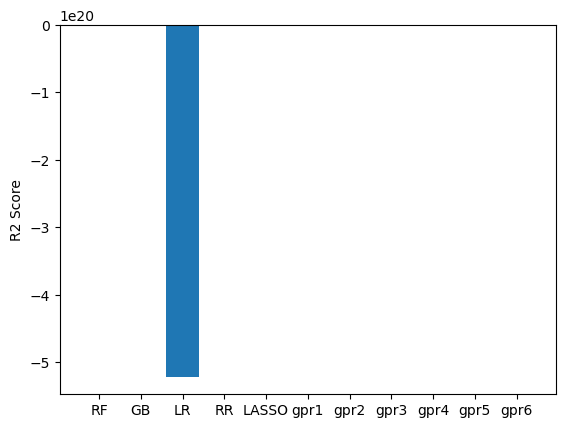

In [34]:
run_models()

In [35]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'X_G', 'A_Rvdw', 'B_Ra', 'A_IEI',
       'A_ChiA', 'B_Hf', 'B_Z', 'A_EA', 'B_Rc', 'A_ChiP', 'B_MP',
       'B_Rvdw', 'B_CvM', 'B_ChiA', 'A_MP', 'B_Rho', 'X_MV'], dtype=object)

In [36]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.8912792855003118
RMSE:  0.07581168381656407
---------------------------------------
GB
R2:  0.807405806663299
RMSE:  0.10090242139100614
---------------------------------------
LR
R2:  0.6473084575290055
RMSE:  0.13654553909663553
---------------------------------------
RR
R2:  0.7610035127454665
RMSE:  0.11240244355414936
---------------------------------------
LASSO
R2:  0.7445940825160887
RMSE:  0.11619714871261051
---------------------------------------
gpr1
R2:  0.6659168281678184
RMSE:  0.13289458761911616
---------------------------------------
gpr2
R2:  0.9122394781864848
RMSE:  0.06811293462588959
---------------------------------------
gpr3
R2:  0.4645933211255233
RMSE:  0.16823714353485802
---------------------------------------
gpr4
R2:  0.8408352610867296
RMSE:  0.09172831679336123
---------------------------------------
gpr5
R2:  0.9252291647293989
RMSE:  0.06287038354819384
---------------------------------------
gpr6
R2:  0.9135752856446197
RMSE:  0.0675925716

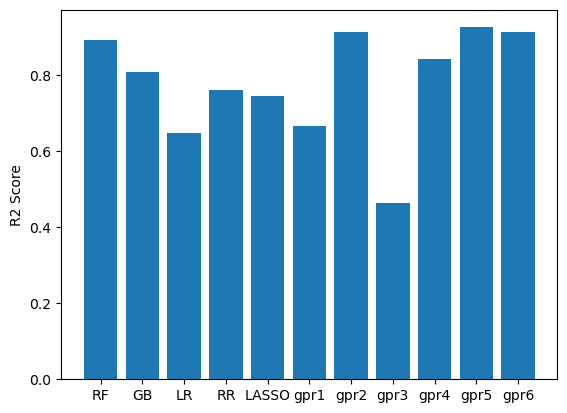

In [37]:
run_models()

In [38]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'X_G', 'A_Rvdw', 'B_Ra', 'A_IEI',
       'A_ChiA', 'B_Hf', 'B_Z'], dtype=object)

In [39]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.8725440293090839
RMSE:  0.08208429757973404
---------------------------------------
GB
R2:  0.8483301018144244
RMSE:  0.08954259808835338
---------------------------------------
LR
R2:  0.918819429438325
RMSE:  0.06550976528350366
---------------------------------------
RR
R2:  0.9192970709874413
RMSE:  0.06531676129919771
---------------------------------------
LASSO
R2:  0.7470838468068366
RMSE:  0.11562940145023091
---------------------------------------
gpr1
R2:  0.9189916461393282
RMSE:  0.06544024208793767
---------------------------------------
gpr2
R2:  0.9276511639359675
RMSE:  0.061843743187373616
---------------------------------------
gpr3
R2:  0.279038016509939
RMSE:  0.19522533473655976
---------------------------------------
gpr4
R2:  0.6824137524993774
RMSE:  0.12957190312178463
---------------------------------------
gpr5
R2:  0.9153482493686946
RMSE:  0.06689566350960649
---------------------------------------
gpr6
R2:  0.9188935710694802
RMSE:  0.0654798436

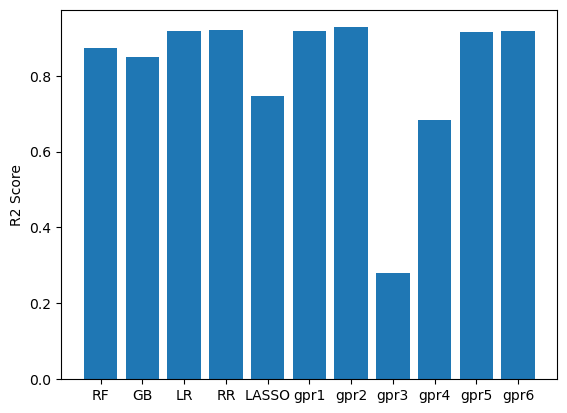

In [40]:
run_models()